## Generate Training and Test Data

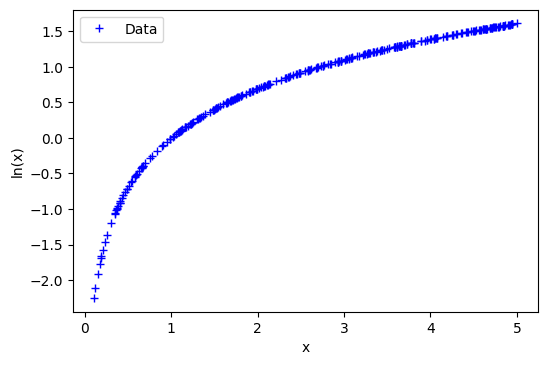

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

trainDataNum = 300
minXTrain = 0.1        # 0 is ill-defined, let's not go there 
maxXTrain = 5          # 5 is enough, we're just trying to see how neural networks work

xTrain = rnd.uniform(minXTrain,maxXTrain,trainDataNum)
yTrain = np.log(xTrain)

plt.figure(dpi=100)
plt.plot(xTrain,yTrain,'b+',label = "Data")
plt.xlabel("x")
plt.ylabel("ln(x)")
plt.legend()
plt.show()

In [2]:
t_x   = list(xTrain)
t_lnx = list(yTrain)
t_x_tensor   = torch.tensor(t_x).unsqueeze(1)
t_lnx_tensor = torch.tensor(t_lnx).unsqueeze(1)

## training and validation set

In [3]:
n_samples  = t_x_tensor.shape[0]
n_val      = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val] # training set indices
val_indices   = shuffled_indices[-n_val:] # validation set indices

t_x_train   = t_x_tensor[train_indices]
t_lnx_train = t_lnx_tensor[train_indices]

t_x_val   = t_x_tensor[val_indices]
t_lnx_val = t_lnx_tensor[val_indices]

Burak: we shouldn't need normalization

In [4]:
#t_un_train = 0.1 * t_u_train
#t_un_val = 0.1 * t_u_val

t_lnx_norm_train = t_lnx_train
t_lnx_norm_val = t_lnx_val
t_x_norm_train = t_x_train
t_x_norm_val = t_x_val

In [5]:
# Type Casting
t_lnx_norm_train = t_lnx_norm_train.type(torch.FloatTensor)
t_lnx_norm_val = t_lnx_norm_val.type(torch.FloatTensor)
t_x_norm_train = t_x_norm_train.type(torch.FloatTensor)
t_x_norm_val = t_x_norm_val.type(torch.FloatTensor)

In [6]:
import torch.nn as nn

model definition (initializes parameters to random values)

In [7]:
linear_model = nn.Linear(1,1,True)
# linear model accepts 3 : input size, output size and bias defaults to True

In [8]:
linear_model.weight

Parameter containing:
tensor([[-0.6339]], requires_grad=True)

we'll check if this changes below to validate the training_loop

train loop definition

In [9]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_lnx_train, t_lnx_val, t_x_train, t_x_val, output_freq):
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        t_p_train  = model(t_x_train) # predicted output
        loss_train = loss_fn(t_p_train, t_lnx_train)
        
        t_p_val = model(t_x_val)
        loss_val = loss_fn(t_p_val, t_lnx_val)
        
        loss_train.backward()
        optimizer.step()
        
        if epoch ==1 or epoch % output_freq == 0:
            #print("predicted t_p_train : ", t_p_train)
            print("Epoch: ", epoch, " Training loss: ", loss_train.item(), " Val loss:", loss_val.item())

optimizer and loss fcn (Adam automatically scales learning rate as the training goes along, better for stability)

In [10]:
optimizer   = optim.Adam(linear_model.parameters(), lr=1e-2)
loss_fcn    = nn.MSELoss()

training_loop(
    n_epochs    = 10000,
    optimizer   = optimizer,
    model       = linear_model,
    loss_fn     = loss_fcn,
    t_lnx_train = t_lnx_norm_train,
    t_lnx_val   = t_lnx_norm_val,
    t_x_train   = t_x_norm_train,
    t_x_val     = t_lnx_norm_val,
    output_freq = 1000
)

Epoch:  1  Training loss:  8.178963661193848  Val loss: 3.6023874282836914
Epoch:  1000  Training loss:  0.08986185491085052  Val loss: 1.1094059944152832
Epoch:  2000  Training loss:  0.0895889475941658  Val loss: 1.1503456830978394
Epoch:  3000  Training loss:  0.0895889475941658  Val loss: 1.1503469944000244
Epoch:  4000  Training loss:  0.0895889550447464  Val loss: 1.15034818649292
Epoch:  5000  Training loss:  0.0895889475941658  Val loss: 1.1503489017486572
Epoch:  6000  Training loss:  0.0895889550447464  Val loss: 1.1503489017486572
Epoch:  7000  Training loss:  0.0895889550447464  Val loss: 1.1503491401672363
Epoch:  8000  Training loss:  0.0895889550447464  Val loss: 1.1503491401672363
Epoch:  9000  Training loss:  0.089588962495327  Val loss: 1.1503491401672363
Epoch:  10000  Training loss:  0.0895889550447464  Val loss: 1.1503493785858154


In [11]:
linear_model.weight

Parameter containing:
tensor([[0.5143]], requires_grad=True)

the parameter changed, the network got trained somehow.

but the "line of best fit" can't really fit an ln() function, so this linear model fails miserably

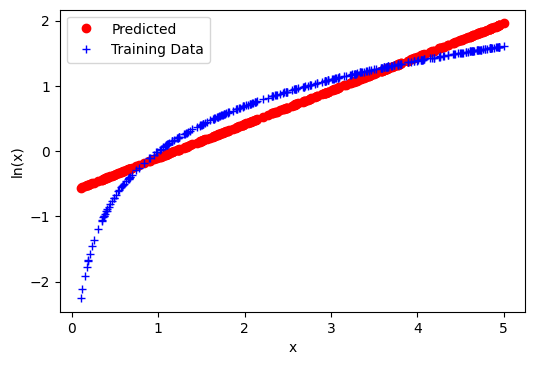

In [12]:
plt.figure(dpi=100)


t_x_tensor_float = t_x_tensor.type(torch.FloatTensor)
t_lnx_tensor_float = t_lnx_tensor.type(torch.FloatTensor)
x_predicted = linear_model(t_x_tensor_float)

plt.plot(t_x_tensor_float,x_predicted.detach().numpy(),'ro', label = "Predicted")
plt.plot(t_x_tensor_float,t_lnx_tensor_float,'b+',label = "Training Data")
plt.xlabel("x")
plt.ylabel("ln(x)")
plt.legend()
plt.show()

### Nonlinear model, but not deep, and not a lot of parameters

In [13]:
nonlin = nn.Sequential(
            nn.Linear(1,3),
            nn.ReLU(),
            nn.Linear(3,1))
nonlin

Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)

In [14]:
optimizer   = optim.Adam(nonlin.parameters(), lr=1e-2)
loss_fcn    = nn.MSELoss()

training_loop(
    n_epochs    = 10000,
    optimizer   = optimizer,
    model       = nonlin,
    loss_fn     = loss_fcn,
    t_lnx_train = t_lnx_norm_train,
    t_lnx_val   = t_lnx_norm_val,
    t_x_train   = t_x_norm_train,
    t_x_val     = t_lnx_norm_val,
    output_freq = 1000
)

Epoch:  1  Training loss:  9.982279777526855  Val loss: 6.110260009765625
Epoch:  1000  Training loss:  0.021663781255483627  Val loss: 1.249396562576294
Epoch:  2000  Training loss:  0.009616592898964882  Val loss: 1.6518934965133667
Epoch:  3000  Training loss:  0.009615892544388771  Val loss: 1.6573575735092163
Epoch:  4000  Training loss:  0.009615889750421047  Val loss: 1.6573607921600342
Epoch:  5000  Training loss:  0.009615892544388771  Val loss: 1.6573631763458252
Epoch:  6000  Training loss:  0.009615893475711346  Val loss: 1.6573638916015625
Epoch:  7000  Training loss:  0.009615892544388771  Val loss: 1.6573646068572998
Epoch:  8000  Training loss:  0.009615892544388771  Val loss: 1.657365322113037
Epoch:  9000  Training loss:  0.009615899994969368  Val loss: 1.657396912574768
Epoch:  10000  Training loss:  0.009615892544388771  Val loss: 1.6567299365997314


### Nonlinear and deeper model, still not many parameters


In [15]:
nonlin_deep = nn.Sequential(
            nn.Linear(1,2),
            nn.ReLU(),
            nn.Linear(2,3),
            nn.ReLU(),
            nn.Linear(3,2),
            nn.ReLU(),
            nn.Linear(2,1)
)

nonlin_deep

Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=1, bias=True)
)

In [16]:
optimizer   = optim.Adam(nonlin_deep.parameters(), lr=1e-2)
loss_fcn    = nn.MSELoss()

training_loop(
    n_epochs    = 10000,
    optimizer   = optimizer,
    model       = nonlin_deep,
    loss_fn     = loss_fcn,
    t_lnx_train = t_lnx_norm_train,
    t_lnx_val   = t_lnx_norm_val,
    t_x_train   = t_x_norm_train,
    t_x_val     = t_lnx_norm_val,
    output_freq = 1000
)

Epoch:  1  Training loss:  0.6310358643531799  Val loss: 0.7970228791236877
Epoch:  1000  Training loss:  0.009615887887775898  Val loss: 1.104581594467163
Epoch:  2000  Training loss:  0.009615888819098473  Val loss: 1.1045814752578735
Epoch:  3000  Training loss:  0.009615892544388771  Val loss: 1.1100484132766724
Epoch:  4000  Training loss:  0.009615892544388771  Val loss: 1.1086983680725098
Epoch:  5000  Training loss:  0.009615891613066196  Val loss: 1.1069328784942627
Epoch:  6000  Training loss:  0.009615892544388771  Val loss: 1.11539626121521
Epoch:  7000  Training loss:  0.009616388007998466  Val loss: 1.1135547161102295
Epoch:  8000  Training loss:  0.00982412789016962  Val loss: 1.133617639541626
Epoch:  9000  Training loss:  0.009615903720259666  Val loss: 1.105666995048523
Epoch:  10000  Training loss:  0.009615899063646793  Val loss: 1.1170871257781982


### Nonlinear, deep and large model

In [17]:
nonlin_deep_large = nn.Sequential(
            nn.Linear(1,10),
            nn.ReLU(),
            nn.Linear(10,20),
            nn.ReLU(),
            nn.Linear(20,40),
            nn.ReLU(),
            nn.Linear(40,30),
            nn.ReLU(),
            nn.Linear(30,10),
            nn.ReLU(),
            nn.Linear(10,1)
)

nonlin_deep_large

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=40, bias=True)
  (5): ReLU()
  (6): Linear(in_features=40, out_features=30, bias=True)
  (7): ReLU()
  (8): Linear(in_features=30, out_features=10, bias=True)
  (9): ReLU()
  (10): Linear(in_features=10, out_features=1, bias=True)
)

In [18]:
optimizer   = optim.Adam(nonlin_deep_large.parameters(), lr=1e-2)
loss_fcn    = nn.MSELoss()

training_loop(
    n_epochs    = 10000,
    optimizer   = optimizer,
    model       = nonlin_deep_large,
    loss_fn     = loss_fcn,
    t_lnx_train = t_lnx_norm_train,
    t_lnx_val   = t_lnx_norm_val,
    t_x_train   = t_x_norm_train,
    t_x_val     = t_lnx_norm_val,
    output_freq = 1000
)

Epoch:  1  Training loss:  1.4770909547805786  Val loss: 1.7345166206359863
Epoch:  1000  Training loss:  0.0015848611947149038  Val loss: 1.2084804773330688
Epoch:  2000  Training loss:  0.00021537566499318928  Val loss: 1.3650028705596924
Epoch:  3000  Training loss:  0.0003307914885226637  Val loss: 1.455865740776062
Epoch:  4000  Training loss:  2.2998192434897646e-05  Val loss: 1.4631580114364624
Epoch:  5000  Training loss:  5.062396667199209e-05  Val loss: 1.4527170658111572
Epoch:  6000  Training loss:  3.337614907650277e-05  Val loss: 1.4615063667297363
Epoch:  7000  Training loss:  1.773060103005264e-05  Val loss: 1.4777648448944092
Epoch:  8000  Training loss:  1.532923852209933e-05  Val loss: 1.481231451034546
Epoch:  9000  Training loss:  0.0004625273577403277  Val loss: 1.440850853919983
Epoch:  10000  Training loss:  1.8633081708685495e-05  Val loss: 1.4814695119857788


this model didn't overfit the train set since we didn't give it a lot of data, but see how validation loss is still very high. 

Overall, the output will look like ln(), but we'll see bad examples 

### Comparing all models

let's just check validation performance

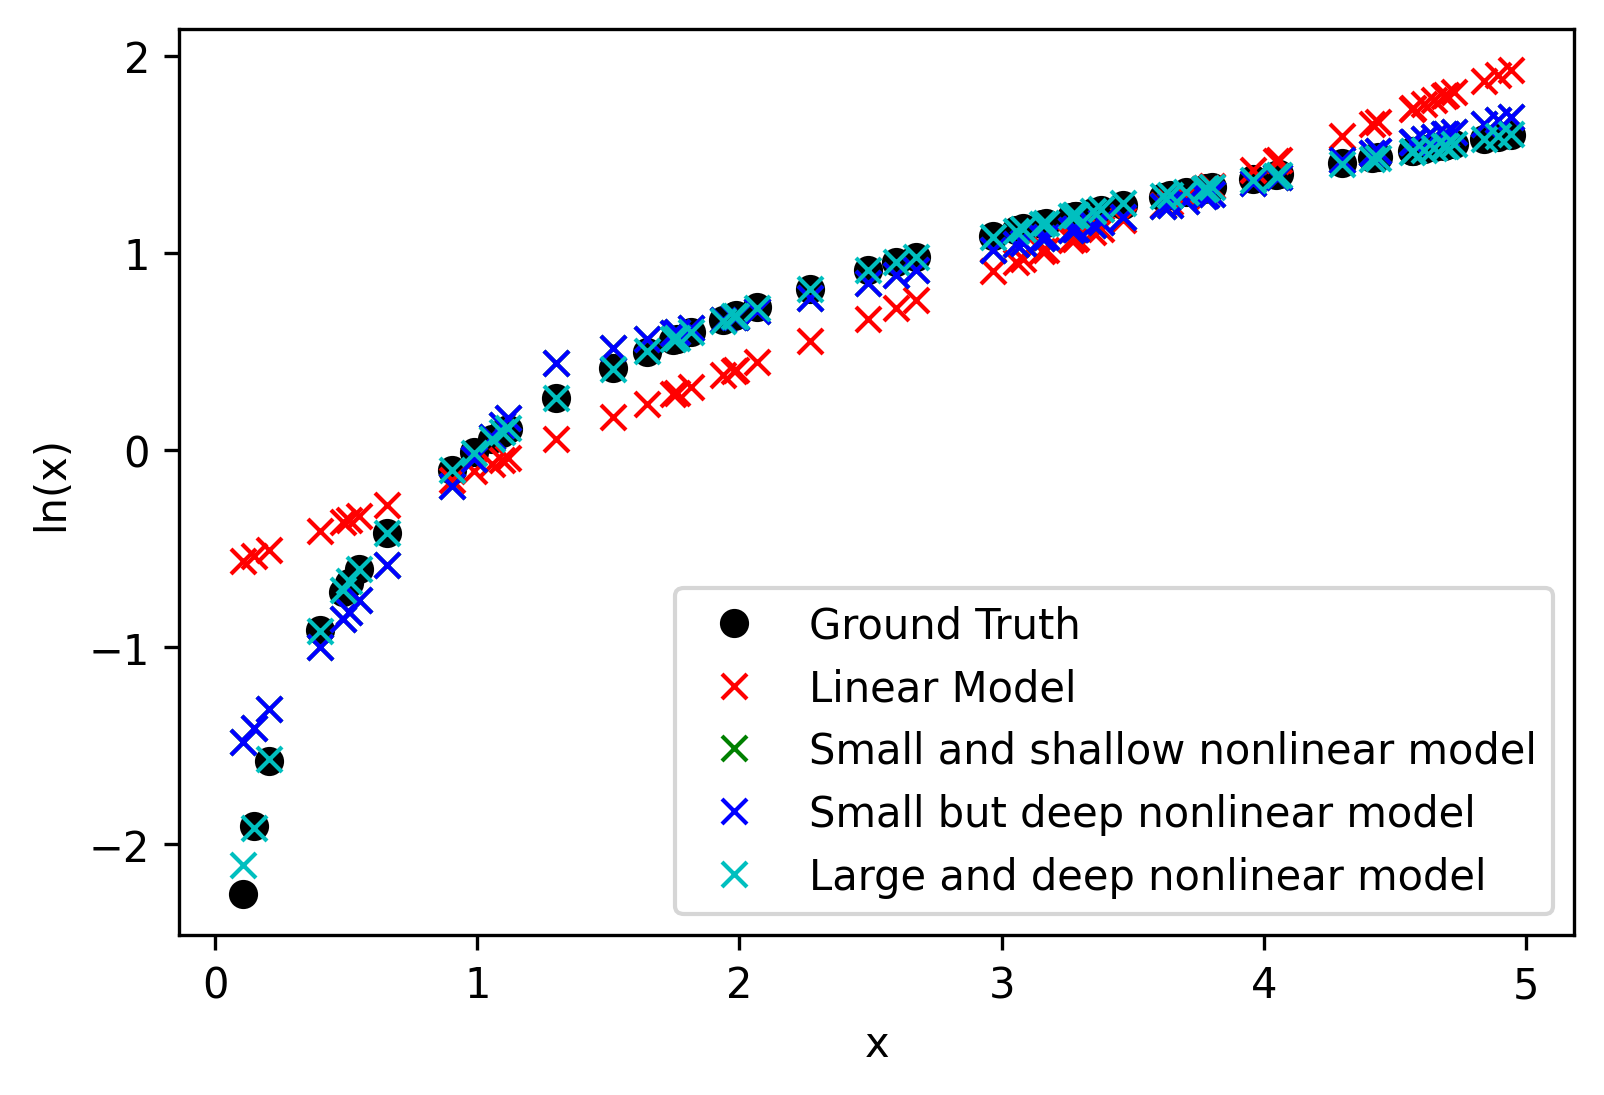

In [19]:
from matplotlib import pyplot as plt

t_range = torch.arange(20.,40.).unsqueeze(1)

fig = plt.figure(dpi=300)

plt.xlabel("x")
plt.ylabel("ln(x)")
plt.plot(t_x_norm_val.numpy(), t_lnx_norm_val.numpy(),'ko', label = "Ground Truth")
plt.plot(t_x_norm_val.numpy(), linear_model(t_x_norm_val.type(torch.FloatTensor)).detach().numpy(),'rx',label = "Linear Model")
plt.plot(t_x_norm_val.numpy(), nonlin(t_x_norm_val.type(torch.FloatTensor)).detach().numpy(), 'gx',label = "Small and shallow nonlinear model")
plt.plot(t_x_norm_val.numpy(), nonlin_deep(t_x_norm_val.type(torch.FloatTensor)).detach().numpy(), 'bx',label = "Small but deep nonlinear model")
plt.plot(t_x_norm_val.numpy(), nonlin_deep_large(t_x_norm_val.type(torch.FloatTensor)).detach().numpy(), 'cx',label = "Large and deep nonlinear model")
plt.legend()